# ¿Existen diferencias significativas entre los saldos de las distintas cohortes de mis clientes?

## Introducción

**Contexto empresarial.** Usted dirige una unidad de análisis empresarial en un banco y se le ha pedido que apoye a la unidad de marketing para realizar un análisis de segmentación de clientes. Se le proporciona un conjunto de datos que comprende una muestra de clientes, los saldos de sus cuentas bancarias y cierta información demográfica sobre ellos. Diferentes poblaciones en todo el país tienen diferentes niveles de ingresos y pueden tener diferentes perfiles de gasto. Su equipo de marketing desea saber si existen diferencias significativas en los saldos bancarios de los diferentes subsegmentos de su base de clientes, de modo que puedan diseñar productos específicos para diferentes grupos.

**Problema empresarial.** El departamento de marketing quiere que determine: **"¿Existen diferencias estadísticamente significativas en los saldos bancarios de sus segmentos de clientes (por edad, trabajo, educación, estado civil, etc.)?"**

**Contexto analítico.** El conjunto de datos que usaremos en este caso se obtuvo de Kaggle (https://www.kaggle.com/skverma875/bank-marketing-dataset). En este caso, daremos el primer paso hacia la transición del **análisis exploratorio de datos** al **análisis confirmatorio**. Vamos a: (1) aprender un marco formal para la prueba de hipótesis; (2) aprender sobre $p$ - valores; (3) generar una hipótesis a partir del análisis exploratorio de datos; y finalmente (4) analizar los resultados de una prueba de hipótesis.

In [2]:
!pip install pingouin

  Created wheel for pingouin: filename=pingouin-0.5.2-py3-none-any.whl size=196207 sha256=d9ed167436a8c42a0147bb0a715bae41ecc796e6fe7c4fc5f1132efa70efe374
  Stored in directory: c:\users\windows\appdata\local\pip\cache\wheels\c0\9f\92\4c574395e1e8e5e08cf73dcb76815a7eaa62921833b6b0f6ad
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=048aa634813c9bae9433aede124f7da94b868d9140e1cd3f4bcfd55428c249b8
  Stored in directory: c:\users\windows\appdata\local\pip\cache\wheels\04\bb\0d\2d02ec45f29c48d6192476bfb59c5a0e64b605e7212374dd15
Successfully built pingouin littleutils


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels
from scipy import stats
from pingouin import pairwise_ttests #this is for performing the pairwise tests

## Exploración de datos

Los datos incluyen el saldo de la cuenta de 45.211 clientes, junto con varias otras características:

In [4]:
bank = pd.read_csv("bank-full.csv")
bank.shape

(45211, 17)

In [5]:
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Variables de interés en este caso son:
* **balance:** bank balance; key variable of interest
* **job:** the title of the job (“management”, “technician”, etc)
* **marital:** marital status ("single", "married" or "divorced")
* **education:** different levels of education ("primary","secondary","tertiary","unknown")
* **default:** the customer defaulted ("yes" or "no")
* **loan:** the customer took out a loan ("yes" or "no")

In [6]:
bank.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


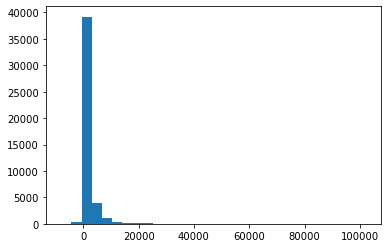

In [7]:
plt.hist(bank['balance'],bins = 30);

### Ejercicio 1:

De las tablas y el histograma anteriores, vemos una gran variedad en el saldo bancario de sus clientes. ¿Por qué crees que es esto?

**Respuesta:** Hay muchos subgrupos en nuestra población. Por ejemplo, hay personas con diversos grados de educación, perfiles laborales, etc. Por lo tanto, esperaremos que estos subgrupos tengan diferentes saldos bancarios.

### Ejercicio 2:
Considere las variables `job`, `marital`, `education`, `default`, `housing`, `loan`. Para cada variable, escriba código para graficas el número de clientes en cada categoría de esa variable, usando el comando `sns.countplot()`.

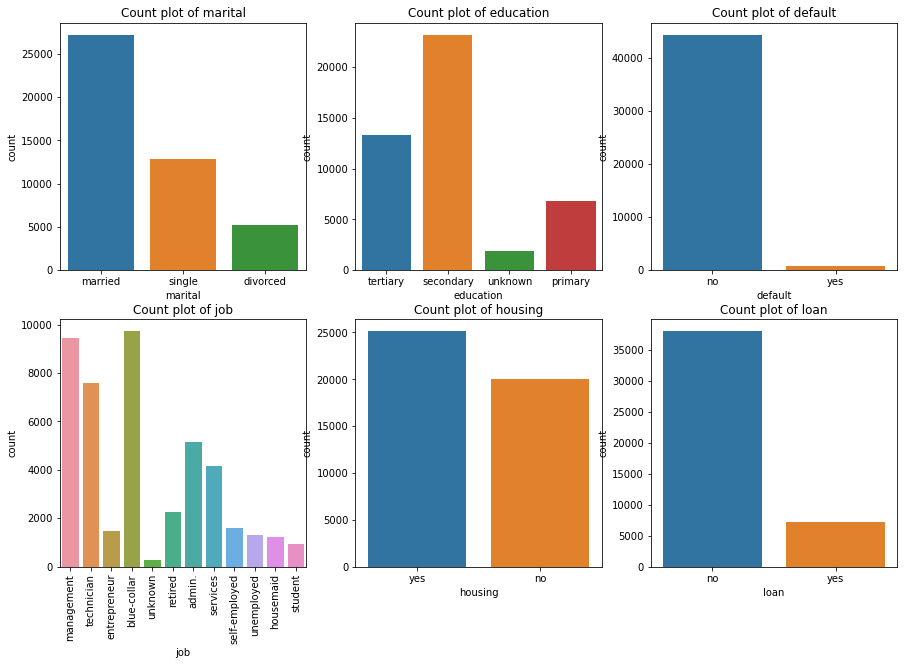

In [9]:
import warnings
warnings.filterwarnings("ignore")
plt.figure(figsize=(15,10))
vars_to_look = ['marital','education','default','job','housing','loan']
for i, var in enumerate(vars_to_look):
    plt.subplot(2,3,i+1)
    if i ==3:
        plt.xticks(rotation = 90)
    sns.countplot(bank[var])
    plt.title("Count plot of " + var)    

### Ejercicio 3:

El año pasado el saldo promedio para toda la población de clientes del banco fue de \\$1341.12. ¿Cuánto más alto es el saldo promedio de la muestra este año? ¿Es esta diferencia significativa?

In [10]:
bank['balance'].mean()

1362.2720576850766

Esta es una diferencia de \\$1362.27 - \\$1341.12 = \\$22.15. La gerencia del banco cree que el comportamiento del consumidor podría haber cambiado ligeramente y que, en promedio, los clientes guardan más dinero en su cuenta bancaria.

Sin embargo, esta diferencia podría deberse a la variación estadística debido a la variabilidad del muestreo. Tendríamos que realizar una prueba más rigurosa para determinar si esta diferencia es realmente significativa después de tener en cuenta dicha variabilidad.

## Marco analítico para la prueba de hipótesis

El procedimiento que usamos para ayudarnos a decidir si una diferencia entre la media $\mu$ de una población y un valor de referencia $\mu_0$ es **estadísticamente significativa** se llama **prueba de hipótesis**. En nuestro contexto,
$\mu$ es el saldo bancario promedio de los clientes este año y $\mu_0$ es su saldo bancario promedio el año pasado.

El primer paso es definir la hipótesis nula (a menudo indicada como $H_0$). La hipótesis nula **siempre** corresponde a la hipótesis de no cambio; es decir, el statu quo sigue siendo válido. Formalmente, esto se escribe como: $ H_0: \mu = \mu_0 $.

En nuestro caso, $H_0$ sería equivalente a la hipótesis de que el saldo promedio para toda la población de clientes $\mu$ es el mismo que el saldo promedio del año pasado $\mu_0 = \$1341.12$. Deseamos probar si $H_0$ está mal; es decir, si $\mu$ es diferente de $\mu_0 = \$1341.12$.

### Pregunta:

Decíamos antes que la hipótesis nula **siempre** corresponde a la hipótesis de no cambio; es decir, el statu quo sigue siendo válido. ¿Por qué es esto? ¿Por qué no establecimos la hipótesis nula para que sea $ H_0: \mu > \mu_0 $?


**Respuesta:** Esto es solo una convención; ninguna otra razón.

### Hipotesis alterna

En oposición a la hipótesis nula, definimos una hipótesis alternativa (a menudo indicada con $H_1$ o $H_a$) para desafiar el statu quo. Podemos tener tres formas diferentes de definir una hipótesis alternativa:

1. $H_a: \mu \neq \mu_0$ (prueba bilateral)

2. $H_a: \mu > \mu_0$ (prueba unilateral)

3. $H_a: \mu < \mu_0$ (prueba unilateral)

La prueba estadística nos ayudará a decidir si hay suficiente evidencia para rechazar la hipótesis nula a favor de una alternativa.

### Realizando la prueba de hipotesis

Volviendo a nuestro caso, supongamos que deseamos realizar una prueba estadística para evaluar la hipótesis de gestión:

$$ H_0: \mu= 1341.12$$
$$ H_a: \mu \neq 1341.12$$

Hay dos resultados posibles para esta prueba: (1) Concluimos que $H_0$ es falso y decimos que **rechazamos $H_0$**. En este caso concluiremos que existe evidencia estadística para la alternativa $H_a$ y que efectivamente el saldo bancario de los clientes este año es diferente a 1341.12 USD. O (2) **no logramos rechazar $H_0$**. En este caso, concluimos que no hay suficiente evidencia estadística para decir con seguridad que $H_0$ es falso. **Tenga en cuenta que en el segundo caso no podemos decir que la hipótesis original es verdadera.** (De hecho, no existe ninguna prueba que le diga que una hipótesis es verdadera. ¿Por qué cree que es así?)

In [11]:
stats.ttest_1samp(bank['balance'], popmean=1341.122)

Ttest_1sampResult(statistic=1.4769973489267905, pvalue=0.13968331332845219)

### Entendiendo a los: $p$ - values

Las pruebas estadísticas reportan un valor de **$p$**. Esta es la cantidad clave que usaremos para determinar si el resultado de la prueba fue significativo. Introduzcamos otra cantidad $\alpha$ a la que llamaremos nivel de significancia; Esto será explicado despues. Por ahora, establece $\alpha = 0.05$.

Podemos tener dos resultados:

1. Si esta probabilidad es menor que nuestro nivel de significancia ($p < \alpha$) rechazamos $H_0$ y afirmamos que la diferencia observada es "estadísticamente significativa".
2. Si esta probabilidad es mayor que nuestro nivel de significancia ($p > \alpha$) tenemos que retener $H_0$ y afirmamos que la diferencia observada no es estadísticamente significativa.

### Pregunta:

¿Qué concluye de la salida? ¿Rechazamos $H_0$ o lo retenemos?

**Respuesta.** Dado que el valor de $p-valor$ (0,13968) es mayor que $\alpha=0,05$, tenemos que conservar la hipótesis nula.

### Pregunta:

¿Qué cambio tenemos que hacer si la alternativa fuera unilateral?

**Respuesta.** Supongamos que nuestra alternativa fuera unilateral: $H_a: \mu > \mu_0$ (prueba unilateral) o $H_a: \mu < \mu_0$ (prueba unilateral). En este caso, simplemente ejecute la prueba de dos caras y luego divida el valor de $p$ por la mitad.

In [13]:
T,p = stats.ttest_1samp(bank['balance'], popmean=1341.122)
p_value = p/2
p_value

0.06984165666422609

### Ejercicio 4:

Retuvimos $H_0$ arriba. ¿Estamos 100% seguros de que esta decisión es correcta? ¿Por qué o por qué no?

**Respuesta:** Dado que los procedimientos estadísticos de prueba de hipótesis apuntan a inferir sobre un parámetro de población desconocido utilizando la información contenida en una muestra, no siempre nos llevará a la decisión correcta. Sin embargo, como aprenderá más adelante, el valor $p$ - nos da una buena idea del grado de confianza que podemos tener en que nuestra conclusión sea correcta. Para la mayoría de las aplicaciones, será suficiente tener al menos un 95 % de confianza.

## Errores debido a una conclusión incorrecta de una prueba de hipótesis

Hay dos formas en que una prueba puede llevarnos a una decisión incorrecta:

1. Cuando $H_0$ es verdadero y lo rechazamos. Esto se llama **Error tipo I**. Corresponde a la obtención de un **falso positivo**.
2. Cuando $H_0$ es falso y no lo rechazamos. Esto se llama **Error de tipo II**. Corresponde a tener un **falso negativo**.

<table>
<tr>
<td></td><td><b>$H_0$ is true </b></td><td><b> $H_0$ is False</b></td>
</tr>
<tr>
<td><b>Reject $H_0$</b></td><td>Type I error</td><td>Correct Decision (True Positive)</td>
</tr>
<tr>
<td><b>Fail to Reject $H_0$ </b></td><td>Correct Decision (True negative) </td><td>Type II error</td>
</tr>
</table>

En general, no podemos controlar tanto el error Tipo I como el Tipo II. Entonces, el tipo de error que controlamos depende de la situación.

### Ejercicio 5:

Discute los siguientes dos escenarios con tus compañeros de equipo:

1. Un paciente se está haciendo una prueba de diagnóstico para averiguar si está infectado con el virus del VIH. ¿Cuál es la hipótesis nula aquí? ¿Qué es más grave aquí: cometer un error de tipo I (falso positivo) o un error de tipo II (falso negativo)? ¿Por qué?
2. Está recibiendo muchos correos electrónicos no deseados, por lo que está escribiendo un algoritmo de filtro de correo no deseado para detectar si un correo electrónico es correo no deseado o no. ¿Cuál es la hipótesis nula aquí? ¿Qué es más grave aquí: cometer un error de tipo I (falso positivo) o un error de tipo II (falso negativo)? ¿Por qué?

**Respuesta.**

1. $H_0$: la persona no tiene VIH. Cometer un error de tipo II es grave aquí, ya que esto podría conducir a una esperanza de vida muy reducida si no reciben los tratamientos adecuados que necesitan.
2. $H_0$: el correo electrónico no es spam. Cometer un error de tipo I es más grave aquí. El error tipo I significa que usted concluye erróneamente que un correo electrónico que no es spam es spam. Esto podría perjudicarlo, ya que es posible que se pierda un correo electrónico importante de su jefe.

## Controlando el error Tipo I: nivel de significación

Es una práctica estándar minimizar la probabilidad de cometer un error de Tipo I. La probabilidad, generalmente denotada por $\alpha$, es el nivel de significación que presentamos anteriormente. Por lo general, elegimos nuestro nivel de significancia $\alpha$ para que sea $5\%$. Por lo tanto, si rechazamos $H_0$ con $\alpha = 0.05$, entonces solo hay una probabilidad de $5\%$ de que la conclusión a la que lleguemos sea un falso positivo. Reducir el valor $\alpha$ (digamos a $1\%$) disminuirá la probabilidad de llegar a una conclusión positiva falsa.

Por supuesto, como discutimos antes, debido a que controlamos $\alpha$, no podemos controlar el error Tipo II que cometemos.

### Encontrar cohortes dentro de su base de clientes

El objetivo de su equipo es determinar si existen diferencias entre los diferentes grupos de clientes en términos de saldos bancarios. Comenzamos observando los saldos de dos cohortes: los que sacaron un préstamo y los que no:

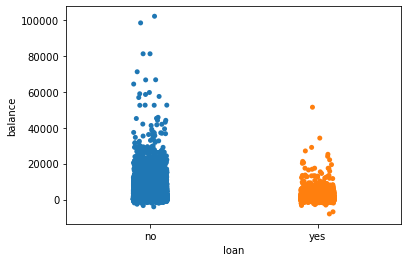

In [14]:
ax = sns.stripplot(x="loan", y="balance", data=bank)
plt.ylabel('balance')
plt.show()

Dado que la distribución de los datos tiene colas gruesas, es difícil decir mucho a partir del diagrama de franjas si existe una diferencia entre las medias de los dos subgrupos. Continuamos nuestro análisis de datos mirando las estadísticas resumidas para cada uno de los dos grupos:

In [15]:
bank[bank.loan=="yes"].balance.describe()

count     7244.000000
mean       774.309912
std       1908.283253
min      -8019.000000
25%          2.000000
50%        258.000000
75%        864.250000
max      51439.000000
Name: balance, dtype: float64

In [16]:
bank[bank.loan=="no"].balance.describe()

count     37967.000000
mean       1474.453631
std        3204.088951
min       -4057.000000
25%          94.000000
50%         496.000000
75%        1558.000000
max      102127.000000
Name: balance, dtype: float64

### ¿Son significativamente diferentes los medios del préstamo y los grupos sin préstamo? (5 metros)

Nos gustaría probar estadísticamente si las medias de los dos grupos son diferentes entre sí; es decir, si la diferencia entre el saldo medio de los grupos con préstamo ($\mu_1$) es diferente al saldo medio del grupo sin préstamo ($\mu_2$). El procedimiento de prueba que describimos también se puede utilizar para responder a esta pregunta:
$$ H_0: \mu_1=\mu_2$$
$$H_a: \mu_1 \neq \mu_2$$

Obtenemos la siguiente salida:

In [17]:
statistic, pvalue = stats.ttest_ind(bank[bank.loan=="yes"].balance, bank[bank.loan=="no"].balance, equal_var=False)
statistic, pvalue

(-25.18086057755715, 2.7640564777544156e-137)

### Pregunta:

¿Qué concluiría de la prueba anterior?

**Respuesta:** El valor de $p$ - es muy pequeño (p = 2,76 e-137); por tanto, rechazamos la hipótesis nula de que los dos grupos tienen la misma media.

### Diferencias por educación:

En nuestra búsqueda para determinar qué factores son importantes en la segmentación de clientes, podemos identificar en este gran conjunto de datos si la educación juega un papel en el comportamiento del cliente. La variable `educación` tiene 4 categorías:

In [18]:
bank["education"].unique()

array(['tertiary', 'secondary', 'unknown', 'primary'], dtype=object)

### Ejercicio 6:

Escriba un código para visualizar el saldo por educación a través de un diagrama de franjas (es decir, un diagrama de dispersión 1D agrupado). A partir de su exploración visual, ¿cree que hay una diferencia entre los grupos?

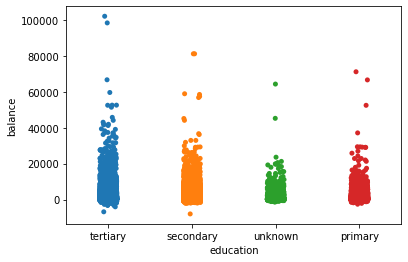

In [19]:
ax = sns.stripplot(x="education", y="balance", data=bank)
plt.ylabel('balance')
plt.show()

**Respuesta.** La representación visual estándar en este caso no proporciona mucha información; por lo tanto, necesitamos un método alternativo para investigar más a fondo.

## ¿Los saldos bancarios difieren significativamente entre las cohortes educativas?

Nuestra nueva hipótesis será:

$$ H_0: \mu_1=\mu_2=\mu_3=\mu_4$$
$$H_a : \mathrm{Al \,menos\, uno\, de\, el\, significa\,} \mu_j \mathrm{\,es \,diferente\, de\, los \,otros}.$$

Para probar esta hipótesis, necesitamos una extensión de las capacidades de la prueba $t$ (que puede probar solo dos grupos al mismo tiempo). Esta prueba se llama **Análisis de varianza (ANOVA)**.

In [20]:
mod = ols('balance ~ education', data=bank).fit()  
aov_table = sm.stats.anova_lm(mod, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
education,3.220417e+09,3.0,116.682074,2.849538e-75
Residual,4.159034e+11,45207.0,NaN,NaN


Como podemos ver, al observar el valor de $p$ - que acompaña a las estadísticas de $F$ -, obtenemos un fuerte rechazo de la hipótesis nula, lo que nos lleva a concluir que los grupos de educación tienen algunas diferencias en sus medias. La prueba ANOVA no nos dice qué par de grupos tienen medias que son diferentes entre sí. Para investigar más a fondo estas diferencias, primero informaremos las estadísticas descriptivas por grupo y luego mostraremos las medias del grupo en un gráfico de barras:

In [21]:
bank[bank.education=="primary"].balance.describe()

count     6851.000000
mean      1250.949934
std       2690.743991
min      -2604.000000
25%         61.000000
50%        403.000000
75%       1390.000000
max      71188.000000
Name: balance, dtype: float64

In [22]:
bank[bank.education=="secondary"].balance.describe()

count    23202.000000
mean      1154.880786
std       2558.256739
min      -8019.000000
25%         55.000000
50%        392.000000
75%       1234.000000
max      81204.000000
Name: balance, dtype: float64

In [23]:
bank[bank.education=="tertiary"].balance.describe()

count     13301.000000
mean       1758.416435
std        3839.088305
min       -6847.000000
25%         104.000000
50%         577.000000
75%        1804.000000
max      102127.000000
Name: balance, dtype: float64

In [24]:
bank[bank.education=="unknown"].balance.describe()

count     1857.000000
mean      1526.754443
std       3152.228273
min      -1445.000000
25%        106.000000
50%        568.000000
75%       1699.000000
max      64343.000000
Name: balance, dtype: float64

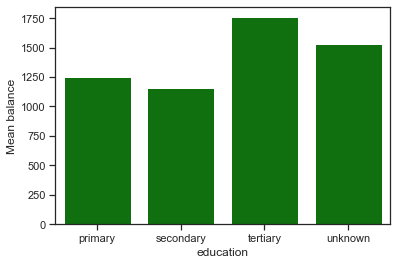

In [18]:
mean_balance_education=bank.groupby(by="education").balance.mean()
sns.barplot(x=mean_balance_education.index, y=mean_balance_education.values, color="green")
plt.ylabel("Mean balance")
plt.show()

Cualitativamente, parece haber una gran diferencia entre los niveles de educación superior e inferior, pero la diferencia entre los grupos de educación primaria y secundaria es más difícil de evaluar. Queremos probar si hay una diferencia significativa en cada comparación por pares. Para probar esta secuencia de hipótesis, podemos usar una variante de la prueba de $t$, llamada prueba de **$t$ por pares**.

In [25]:
gb = bank.groupby(['education'])
group_names = bank["education"].unique()
print("\t\t\tstatistic\t\tpvalue")
for i in range(len(group_names)):
  for j in range(i+1, len(group_names)):
    group1 = gb[["balance"]].get_group(group_names[i])
    group2 = gb[["balance"]].get_group(group_names[j])
    stat, pvalue = stats.ttest_ind(group1, group2, equal_var = False)
    print(group_names[i] + " vs. " + group_names[j] + "\t" + str(stat[0]) + "\t" + str(pvalue[0]))

			statistic		pvalue
tertiary vs. secondary	16.18717929985782	1.4525474790099814e-58
tertiary vs. unknown	2.8825321831203117	0.003976238237673688
tertiary vs. primary	10.906634331433306	1.3023845080432282e-27
secondary vs. unknown	-4.95482328681934	7.83111710943088e-07
secondary vs. primary	-2.6255174227477864	0.0086639693661419
unknown vs. primary	3.445496944400963	0.0005789323657180873


El resultado de resumen anterior indica que hay una diferencia significativa entre cada comparación por pares.

### Ejercicio 7:

Hay seis comparaciones en total que deben realizarse porque la variable educación tiene 4 niveles. Discute con un compañero si, en tu opinión, realizar múltiples pruebas simultáneamente puede aumentar el riesgo de inferencias erróneas.

¿Qué aumentará: error tipo I o error tipo II?

**Respuesta.** Sí, cuantas más comparaciones realicemos simultáneamente, mayor será el riesgo de observar algunos "falsos positivos" o cometer un error de tipo I. Básicamente, si torturas los datos lo suficiente, confesará.

### Comparaciones multiples: correcion de Bonferroni 

Hay muchas formas de corregir este problema, conocido como el problema de las "comparaciones múltiples". Uno de los métodos más clásicos es la corrección de Bonferroni. Este método divide el nivel de significación $\alpha$ por el número de comparaciones múltiples que se realizan (6 en este caso). Entonces, si nuestro $\alpha=0.05$, rechazaremos la hipótesis nula solo si el valor de $p$ es menor que 0.00833.

Observe que el valor de $p$ - para la comparación entre educación "primaria" y "secundaria" es 0.02126 y, por lo tanto, es más alto que el nivel de confianza ajustado. Después de la corrección no podemos rechazar la hipótesis nula de que este par tiene medias significativamente diferentes. Varios paquetes de software ajustan directamente los valores de $p$ para aumentar la probabilidad de observar un falso positivo. Si realizamos este método para `educación`, obtenemos el siguiente resultado:

In [26]:
pairwise_results = pairwise_ttests(dv='balance', between = ['education'], padjust='bonf', data=bank)
pairwise_results

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,education,primary,secondary,False,True,2.625517,10768.241876,two-sided,8.663969e-03,5.198382e-02,bonf,0.486,0.037105
1,education,primary,tertiary,False,True,-10.906634,18353.418018,two-sided,1.302385e-27,7.814307e-27,bonf,9.088e+23,-0.145344
2,education,primary,unknown,False,True,-3.445497,2633.681528,two-sided,5.789324e-04,3.473594e-03,bonf,10.941,-0.098651
3,education,secondary,tertiary,False,True,-16.187179,20183.403282,two-sided,1.452547e-58,8.715285e-58,bonf,5.742e+54,-0.195497
4,education,secondary,unknown,False,True,-4.954823,2056.380989,two-sided,7.831117e-07,4.698670e-06,bonf,5633.685,-0.142646
5,education,tertiary,unknown,False,True,2.882532,2688.204879,two-sided,3.976238e-03,2.385743e-02,bonf,1.76,0.061581


En la tabla anterior, ``p-unc`` representa el valor de $p$ no corregido, y ``p-adjust`` representa el valor de $p$ corregido. El valor $p$ ajustado para "secundario frente a primario" es 0,052 (mayor que 0,05), lo que confirma nuestro cálculo. Por lo tanto, rechazamos todas las hipótesis nulas excepto el caso de "secundaria versus primaria".

### Ejercicio 8:

Realice un análisis exploratorio de datos del saldo bancario por puesto de trabajo. Escriba código para responder a las siguientes dos preguntas:

1. ¿Los medios del grupo son los mismos? Escribe una hipótesis para esto, indicando claramente qué es $H_0$.
2. Hacer una prueba de hipótesis por pares para comparar las medias de los diferentes grupos, aplicando la corrección de Bonferroni.
3. ¿Le sorprende alguno de los resultados de las pruebas de hipótesis de los clientes en la gestión frente a otros grupos?

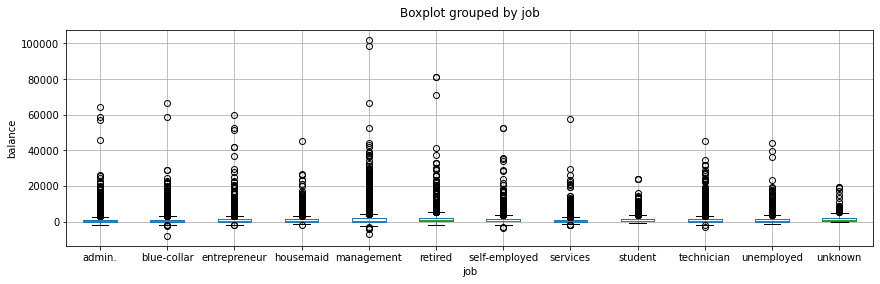

In [27]:
boxplot = bank.boxplot(column=['balance'], by="job",figsize=(14,4))
boxplot.axes.set_title("")
plt.ylabel('balance')
plt.show()

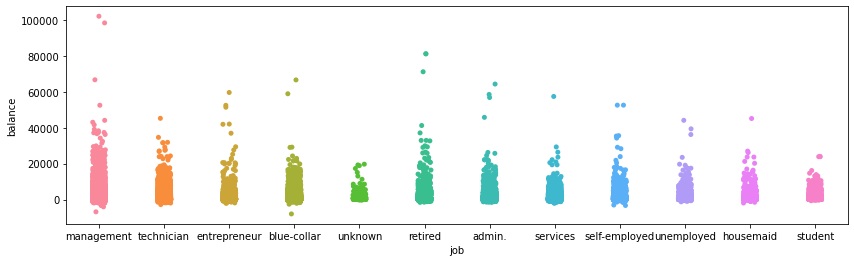

In [28]:
plt.figure(figsize=(14,4))
ax = sns.stripplot(x="job", y="balance", data=bank)
plt.ylabel('balance')
plt.show()

In [29]:
mod = ols('balance ~ job', data=bank).fit()  
aov_table = sm.stats.anova_lm(mod, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
job,4.341414e+09,11.0,43.007783,5.709430e-94
Residual,4.147824e+11,45199.0,NaN,NaN


In [30]:
pairwise_job_results = pairwise_ttests(dv='balance', between = ['job'], padjust='bonf', data=bank)
pairwise_job_results[pairwise_job_results['A']=='management']

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
38,job,management,retired,False,True,-2.196665,3131.535808,two-sided,2.811739e-02,1.000000e+00,bonf,0.293,-0.055981
39,job,management,self-employed,False,True,1.148353,2184.520136,two-sided,2.509488e-01,1.000000e+00,bonf,0.059,0.030404
40,job,management,services,False,True,14.825903,12787.547265,two-sided,2.556646e-49,1.687386e-47,bonf,4.105e+45,0.225194
41,job,management,student,False,True,4.225002,1439.557060,two-sided,2.539487e-05,1.676061e-03,bonf,276.437,0.100961
42,job,management,technician,False,True,10.429971,16520.443985,two-sided,2.169693e-25,1.431997e-23,bonf,5.845e+21,0.154074
43,job,management,unemployed,False,True,2.530687,1875.469495,two-sided,1.146511e-02,7.566972e-01,bonf,0.809,0.064539
44,job,management,unknown,False,True,-0.048726,316.659804,two-sided,9.611682e-01,1.000000e+00,bonf,0.067,-0.002300


El saldo de la cuenta de clientes desempleados y clientes de administración no es significativamente diferente, ¡y esto es sorprendente!

## Conclusiones

Después de realizar un análisis exploratorio de datos, presentamos formalmente las pruebas de hipótesis. Vimos que el nivel de educación definitivamente afecta el saldo bancario; los clientes con educación terciaria parecen tener una diferencia estadísticamente significativa en el saldo bancario en comparación con el resto de la población. Sin embargo, después de ajustar por múltiples pruebas, no parece haber una diferencia estadísticamente significativa entre los clientes con educación primaria y secundaria. También vimos algunas diferencias estadísticamente significativas en los saldos bancarios de clientes con diferentes perfiles de trabajo.

## Adicionales

La segmentación de clientes requiere analizar las diferencias entre diferentes subgrupos de clientes. Las diferencias observadas no corresponden necesariamente a diferencias estadísticamente significativas. La prueba de hipótesis puede ayudarnos a identificar diferencias que son demasiado extremas para que sucedan al azar.

Sin embargo, la prueba de hipótesis no es solo una aplicación rutinaria de reglas; tenemos que ser conscientes del problema de las comparaciones múltiples. De ahí viene el problema de los "monos en una máquina de escribir". Una corrección de Bonferroni contribuye en gran medida a mitigar el problema de observar demasiados resultados falsos positivos al realizar una gran cantidad de pruebas de hipótesis.